In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import jax
import pennylane as qml
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
from pennylane import numpy as qnp

from scipy.integrate import trapezoid
import time
import pickle
import warnings
warnings.filterwarnings("ignore")

jax.config.update("jax_enable_x64", True)

### Generating Bars and Stripes dataset

In [2]:
def get_bars_and_stripes(n):
    bitstrings = [list(np.binary_repr(i, n))[::-1] for i in range(2**n)]
    bitstrings = np.array(bitstrings, dtype=int)

    stripes = bitstrings.copy()
    stripes = np.repeat(stripes, n, 0)
    stripes = stripes.reshape(2**n, n * n)

    bars = bitstrings.copy()
    bars = bars.reshape(2**n * n, 1)
    bars = np.repeat(bars, n, 1)
    bars = bars.reshape(2**n, n * n)

    return np.vstack((stripes[0 : stripes.shape[0] - 1], bars[1 : bars.shape[0]]))

n = 2
size = n**2
data = get_bars_and_stripes(n)
# print(data.shape)



Sample bitstring: 1010


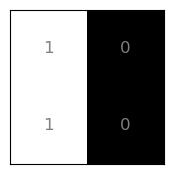

In [3]:
import matplotlib.pyplot as plt

sample = data[1].reshape(n, n)

plt.figure(figsize=(2, 2))
plt.imshow(sample, cmap="gray", vmin=0, vmax=1)
plt.grid(color="gray", linewidth=2)
plt.xticks([])
plt.yticks([])

for i in range(n):
    for j in range(n):
        text = plt.text(
            i,
            j,
            sample[j][i],
            ha="center",
            va="center",
            color="gray",
            fontsize=12,
        )

print(f"\nSample bitstring: {''.join(np.array(sample.flatten(), dtype='str'))}")

### Getting Wavefunction of Dataset

In [7]:
target_psi = np.zeros(2**4)
bitstrings_target = ['0000','0011','0101','1010','1100','1111']
nums_target = []
for i in bitstrings_target:
    nums_target += [int(i, 2)]
print(nums_target)

[0, 3, 5, 10, 12, 15]


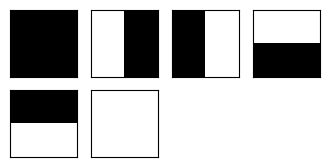

In [8]:
plt.figure(figsize=(4, 4))
j = 1
for i in data:
    plt.subplot(4, 4, j)
    j += 1
    plt.imshow(np.reshape(i, (n, n)), cmap="gray", vmin=0, vmax=1)
    plt.xticks([])
    plt.yticks([])

In [9]:
target_amps = 1/math.sqrt(len(nums_target))
for i in nums_target:
    target_psi[i] = target_amps

In [10]:
target_psi

array([0.40824829, 0.        , 0.        , 0.40824829, 0.        ,
       0.40824829, 0.        , 0.        , 0.        , 0.        ,
       0.40824829, 0.        , 0.40824829, 0.        , 0.        ,
       0.40824829])

In [11]:
target_dm = np.outer(target_psi,target_psi.conj())


In [12]:
target_dm

array([[0.16666667, 0.        , 0.        , 0.16666667, 0.        ,
        0.16666667, 0.        , 0.        , 0.        , 0.        ,
        0.16666667, 0.        , 0.16666667, 0.        , 0.        ,
        0.16666667],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.16666667, 0.        , 0.        , 0.16666667, 0.        ,
        0.16666667, 0.        , 0.        , 0.        , 0.        ,
        0.16666667, 0.        , 0.16666667, 0.        , 0.        ,
        0.16666667],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 

In [ ]:
################ Checking the pennylane function qml.math.reduce_statevector()


# bitstrings = ['0000000','0011001','0101010','1010011','1100100','1111101']
# nums = []
# for i in bitstrings:
#     nums += [int(i, 2)]
# print(nums)

# psi = np.zeros(2**7)
# amps = 1 / math.sqrt(len(bitstrings))
# for i in nums:
#     psi[i] = amps
# dm = np.outer(psi,psi.conj())

# reduced_dm = qml.math.reduce_statevector(target_psi,indices=[0,1,2,3])
# # reduced_dm = qml.math.reduce_dm(dm,indices=[0,1,2,3])

# pxy = reduced_dm - target_dm
# dagger_pxy = qml.math.conj(qml.math.transpose(pxy)) # Compute Hermitian conjugate
# loss = 0.5 * qml.math.trace(qml.math.sqrt_matrix(dagger_pxy * pxy))
# loss


### Functions

In [14]:
from pennylane.math import reduce_statevector
from pennylane import math as qmlmath

n_qubits = 4
n_ancillas = 4
total_qubits = n_qubits + n_ancillas

class TraceDistanceLoss:
    """
    Loss class to compute the trace distance between two probability distributions.
    
    The loss is defined as:
    
        loss(px, py) = 0.5 * trace(sqrt((px - py)† * (px - py)))
    
    Note: The square root here is applied element-wise.
    """

    def __init__(self):
        # You can initialize parameters here if needed.
        pass

    def tr_distance(self, pxy):
        """
        Compute the trace distance of the difference matrix pxy.
        
        Parameters:
            pxy (numpy.ndarray): Difference of two probability distributions.
        
        Returns:
            float: 0.5 * trace of the element-wise square root of (pxy† * pxy).
        """
        dagger_pxy = qmlmath.conj(qmlmath.transpose(pxy)) # Compute Hermitian conjugate
        return 0.5 * qmlmath.trace(qmlmath.sqrt_matrix(dagger_pxy * pxy))
        # return qnp.linalg.norm(pxy)  # temporary fix

    def __call__(self, px, py):
        """
        Compute the loss given two probability distributions px and py.
        
        Parameters:
            px, py (numpy.ndarray): Input probability distributions.
        
        Returns:
            float: Computed loss.
        """
        pxy = px - py
        return self.tr_distance(pxy)
    
class QCBM:

    def __init__(self,circ,trdistance,py):
        self.circ = circ
        self.trdistance = trdistance
        self.py = py

    def qcbm_loss(self,params):
        full_psi = self.circ(params)
        px = reduce_statevector(full_psi,indices=range(n_qubits))
        loss = self.trdistance(px,self.py)
        # print("Statevector is",full_psi)
        return qnp.real(loss)

In [ ]:
def qcbm_circuit(params,total_qubits):

    rz_params = params[:total_qubits]
    ising_params1 = params[total_qubits:2*total_qubits]
    ising_params2 = params[2*total_qubits:]

    for i in range(total_qubits):
        qml.RX(rz_params[i],wires=i)

    for i in range(total_qubits-1):
        qml.IsingXY(ising_params1[i],wires=[i,i+1])
    qml.IsingXY(ising_params1[-1],wires=[total_qubits-1,0])


    for i in range(total_qubits-1):
        qml.IsingZZ(ising_params2[i],wires=[i,i+1])
    qml.IsingZZ(ising_params2[-1],wires=[total_qubits-1,0])


dev = qml.device("default.qubit",wires=total_qubits)
folds = 3

@qml.qnode(dev,diff_method="backprop",interface="autograd")
def circuit(input_params,folds=folds,num_qubits=n_qubits,ancilla_qubits=n_ancillas,total_qubits=total_qubits):
    
    params = qnp.array(input_params, requires_grad=True)
    
    for i in range(total_qubits):

        ## 1010.... initial state
        if i%2 == 0:
            qml.X(i)

    for i in range(folds):
        qcbm_circuit(params=params[i],total_qubits=total_qubits)
    
    output1 = qml.state()

    return output1


### Training the Model

In [16]:
key = jax.random.PRNGKey(1)
initial_params = qnp.random.uniform(low=0.0, high=1.0, size=(folds, 3 * total_qubits), requires_grad=True)

#initial_params = jax.random.uniform(key, shape=(folds, (3 * total_qubits)), minval=0.0, maxval=2*math.pi)

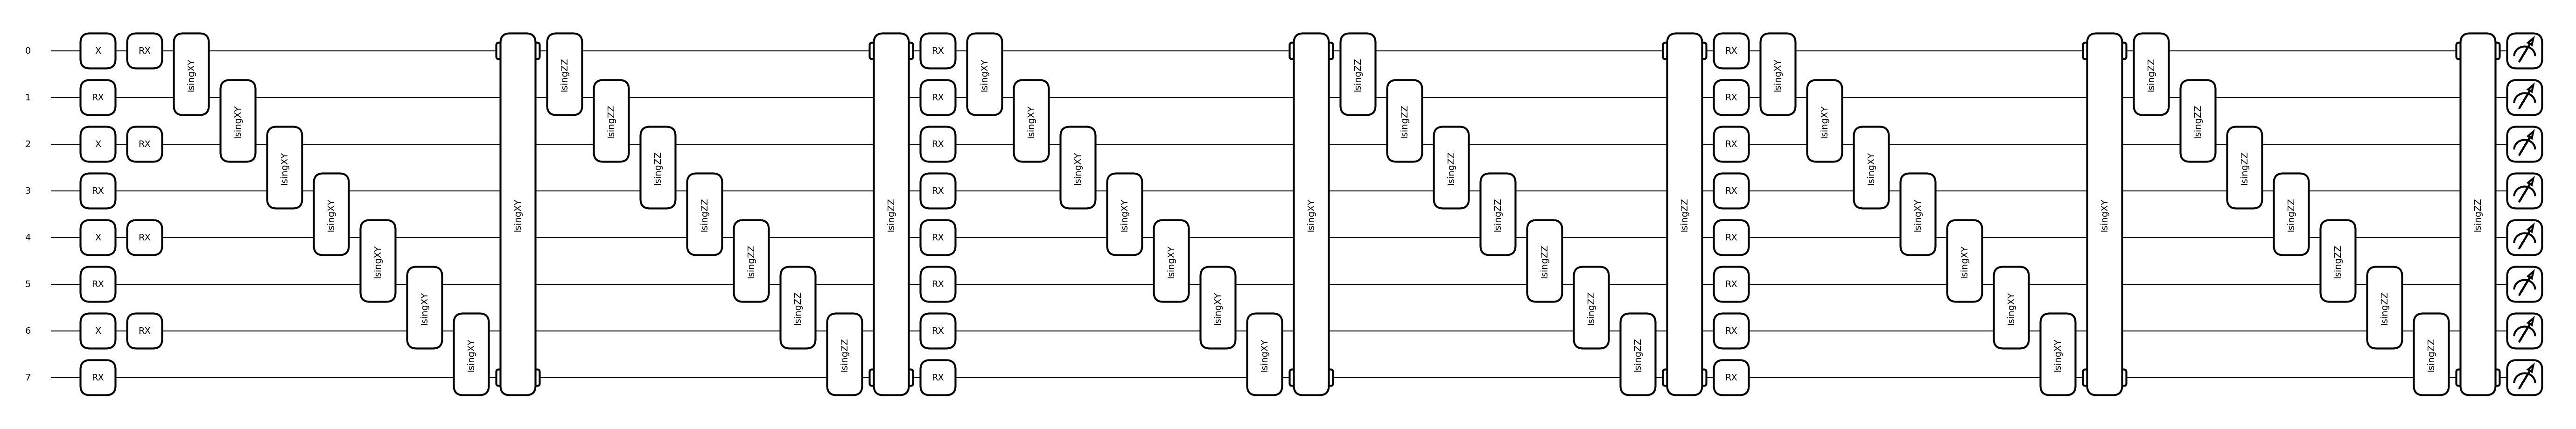

In [17]:
qml.draw_mpl(circuit,device='default')(initial_params)
plt.show()

In [18]:
tr_distance = TraceDistanceLoss()
qcbm = QCBM(circuit,tr_distance,target_dm)

weights = initial_params#.flatten()
# lr = 1
opt = AdamOptimizer(stepsize=0.01)
# opt = GradientDescentOptimizer(stepsize=0.1)
# opt_state = opt.init(weights)

loss = []
parameters = []
n_epochs = 2000
i = 0

while i < n_epochs:

    i += 1
    start_time = time.time()
    loss_val = qcbm.qcbm_loss(weights)
    weights = opt.step(qcbm.qcbm_loss,weights)
    # grad = grad(qcbm.qcbm_loss)()
    end_time = time.time()

    if i%10 == 0:
        print(f"Step: {i} Loss: {loss_val} Time taken per iter: {end_time-start_time}")

    loss.append(loss_val)
    parameters.append(weights)


Step: 10 Loss: 0.48741319058203203 Time taken per iter: 0.021160125732421875
Step: 20 Loss: 0.4623322592461892 Time taken per iter: 0.026788949966430664
Step: 30 Loss: 0.42784702401707364 Time taken per iter: 0.021936893463134766
Step: 40 Loss: 0.37993099312887496 Time taken per iter: 0.021928071975708008
Step: 50 Loss: 0.3252861398718312 Time taken per iter: 0.024995088577270508
Step: 60 Loss: 0.28007577942873363 Time taken per iter: 0.02604985237121582
Step: 70 Loss: 0.2426954599530759 Time taken per iter: 0.022775888442993164
Step: 80 Loss: 0.21039108947708204 Time taken per iter: 0.021101951599121094
Step: 90 Loss: 0.1711687189387093 Time taken per iter: 0.022213220596313477
Step: 100 Loss: 0.1467885827177617 Time taken per iter: 0.02200484275817871
Step: 110 Loss: 0.13068158016958165 Time taken per iter: 0.053270816802978516
Step: 120 Loss: 0.12909152640722016 Time taken per iter: 0.02212810516357422
Step: 130 Loss: 0.11897115515972295 Time taken per iter: 0.0230100154876709
Step:

Text(0, 0.5, 'Trace distance Loss')

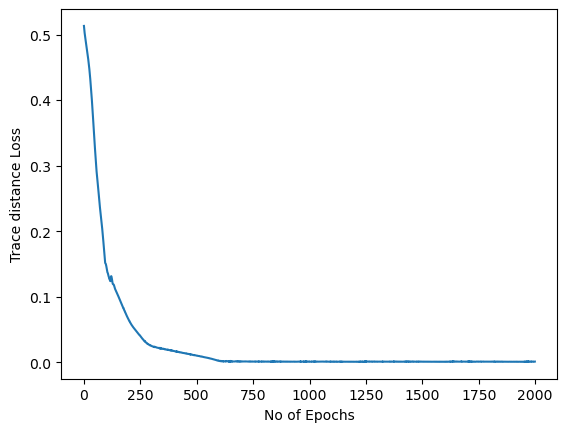

In [19]:
plt.plot(loss)
plt.xlabel("No of Epochs")
plt.ylabel("Trace distance Loss")

In [20]:
min_loss = loss[np.argmin(loss)]

print(f"The model converges to the Trace Distance Loss of {min_loss}")

The model converges to the Trace Distance Loss of 0.0004407013253003904
